In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 1 Load the data
path_file = os.path.join("../dataset", "matje.csv")
df = pd.read_csv(path_file)

In [3]:
# Step 2 Preprocess the data
# Define the number of lags (the number of past time points you want to use)
num_lags = 3
lag_features = ['pm2_5', 'pm10', 'temp', 'trysnia', 'lageshtira']

df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# Feature engineering: Create lagged features
for lag in range(1, num_lags + 1):
    for feature in lag_features:
        df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

# Remove rows with missing values after lagging
df.dropna(inplace=True)

# Define features and target
features = lag_features + [f"{feature}_lag{lag}" for feature in lag_features for lag in range(1, num_lags + 1)]
X = df[features]
y = df['alarm_status']

In [4]:
# Step 3 Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [5]:
# Step 4 Predict function that makes sure the feature set matches the training set
def make_prediction(model, current_data, num_lags):
    # Shift the lagged features to create a new row for prediction
    new_row = current_data[-1:].copy()
    for lag in range(num_lags, 0, -1):
        for feature in lag_features:
            if lag == 1:
                # For lag1, we set the current observed values
                new_row[f'{feature}_lag1'] = current_data[feature].iloc[-1]
            else:
                # For other lags, we shift the previous lags down by one
                new_row[f'{feature}_lag{lag}'] = new_row[f'{feature}_lag{lag-1}'].values

    # Ensure the new row has the same feature order as the training set
    new_row = new_row[features]

    # Reshape the data for the model if necessary
    prediction_features = new_row.values.reshape(1, -1)

    # Make the prediction
    return model.predict(prediction_features)

In [6]:
# Step 5 Predict next future alarms in a time series, for next 3 hours
# Use the last available data point as initial input
#last_hour_data = X.iloc[-1].values.reshape(1, -1)  # Use the last hour's data
last_data_point = X.iloc[[-1]].copy()

future_predictions = []  # To store the predicted alarm values

for _ in range(8):
    # Predict the alarm for the next 30 minutes
    #last_data_point_without_status = last_data_point
    prediction = make_prediction(model, X, num_lags)
    #print(prediction)
    #predicted_alarm = model.predict(last_data_point_without_status)
    future_predictions.append(prediction[0])

    # Shift the data by 30 minutes (half hour)
    last_data_point = last_data_point.shift(periods=1, freq='30T')
    last_data_point.at[last_data_point.index[-1], 'alarm_status'] = prediction[0]  # Update the last alarm_status value


print("Predicted alarm values for the next 4 hours:", future_predictions)


Predicted alarm values for the next 4 hours: [1, 1, 1, 1, 1, 1, 1, 1]


/Users/edmond/github/iot_air_quality_ml/notebooks/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/yp/h83thx8j2nd0vgffqxx1p8rc0000gn/T/ipykernel_5672/756543559.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  last_data_point = last_data_point.shift(periods=1, freq='30T')
/Users/edmond/github/iot_air_quality_ml/notebooks/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/yp/h83thx8j2nd0vgffqxx1p8rc0000gn/T/ipykernel_5672/756543559.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  last_data_point = last_data_point.shift(periods=1, freq='30T')
/Users/edmond/github/iot_air_quality_ml/notebooks/

/var/folders/yp/h83thx8j2nd0vgffqxx1p8rc0000gn/T/ipykernel_5672/3764915624.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  predicted_index = pd.date_range(start=df.index[-1], periods=8, freq='30T')[1:]


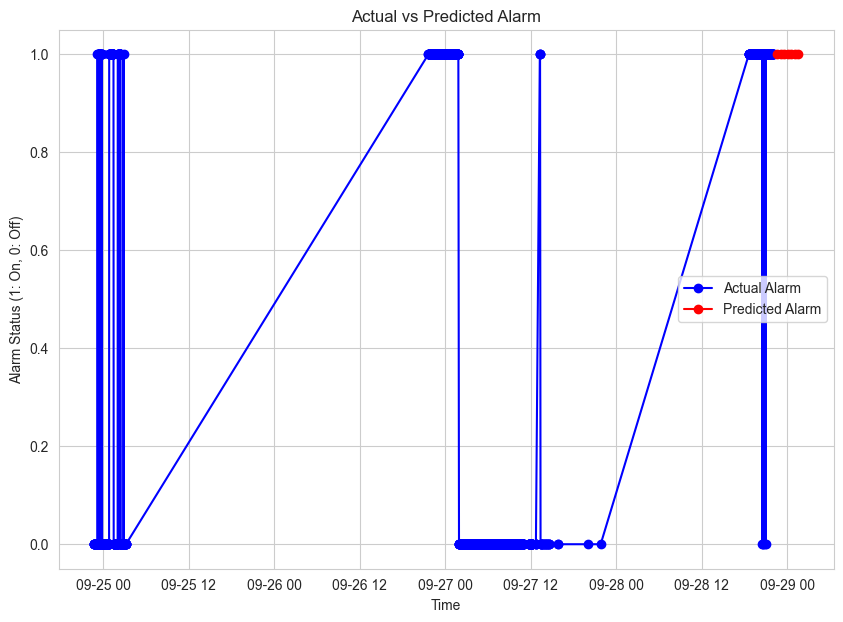

In [7]:
# Step 6: Visualize the predictions
plt.figure(figsize=(10, 7))

# Plot actual alarms
plt.plot(np.array(df.index), df['alarm_status'].values, label='Actual Alarm', color='blue', marker='o')

# Plot predicted alarms
predicted_index = pd.date_range(start=df.index[-1], periods=8, freq='30T')[1:]
plt.plot(np.array(predicted_index), np.array(future_predictions)[:-1], label='Predicted Alarm', color='red', marker='o')

plt.title('Actual vs Predicted Alarm')
plt.xlabel('Time')
plt.ylabel('Alarm Status (1: On, 0: Off)')
plt.legend()
plt.show()
